In [1]:
import pandas as pd
df = pd.read_csv('smoking.csv')
df = df[:10000]

C:\Users\claud\AppData\Local\Temp\ipykernel_18520\362415711.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = df.drop(['ID', 'height(cm)', 'oral'], axis=1)
df['tartar'] = df['tartar'].apply(lambda x: 1 if x == 'Y' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('smoking', axis=1)
y = df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Fai le predizioni sul set di test
y_true = np.ones(len(y_test))
y_pred = np.ones(len(y_test))

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)

Matrice di Confusione:
[[   0 1941]
 [   0 1059]]


In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(model, filled=True, ax=ax)
plt.plot()

[]

In [7]:
from sklearn.metrics import classification_report

# predizione del nuovo modello
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)

print("Test Set Performance:")
print(classification_report(y_test, y_pred))

Confusion matrix:
 [[1442  499]
 [ 429  630]]
Test Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1941
           1       0.56      0.59      0.58      1059

    accuracy                           0.69      3000
   macro avg       0.66      0.67      0.67      3000
weighted avg       0.70      0.69      0.69      3000


Accuracy: 0.6906666666666667


In [8]:
# andiamo a lavorare sul parametro di complessità, che stima il vantaggio di aggiungere/togliere degli split
# in funzione degli errori di classificazione
# più il modello è complesso e più viene penalizzato
path = model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

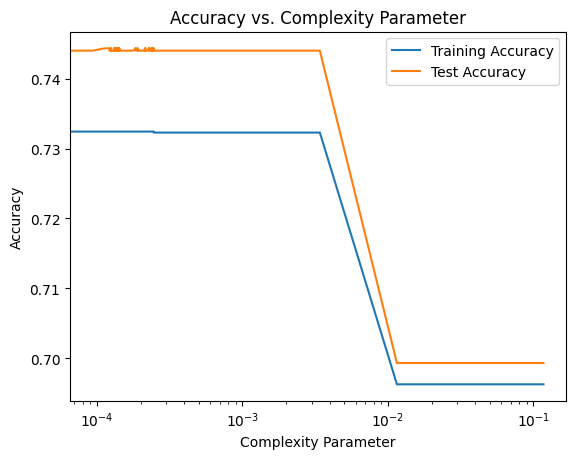

In [9]:
# valori di complessità candidati ad essere tagliati dal modello
# complexity_values = [0.001, 0.01, 0.1, 1, 10, 100]
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [10]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.11735577440370953


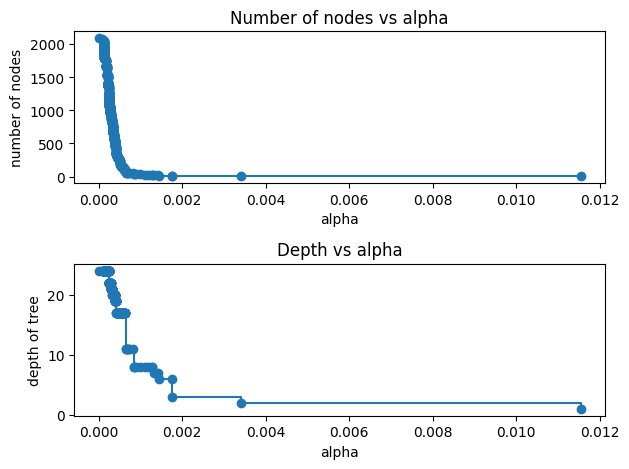

In [11]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [13]:
# Potiamo albero con alpha=0.001
clf_pruned = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.001)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=3)

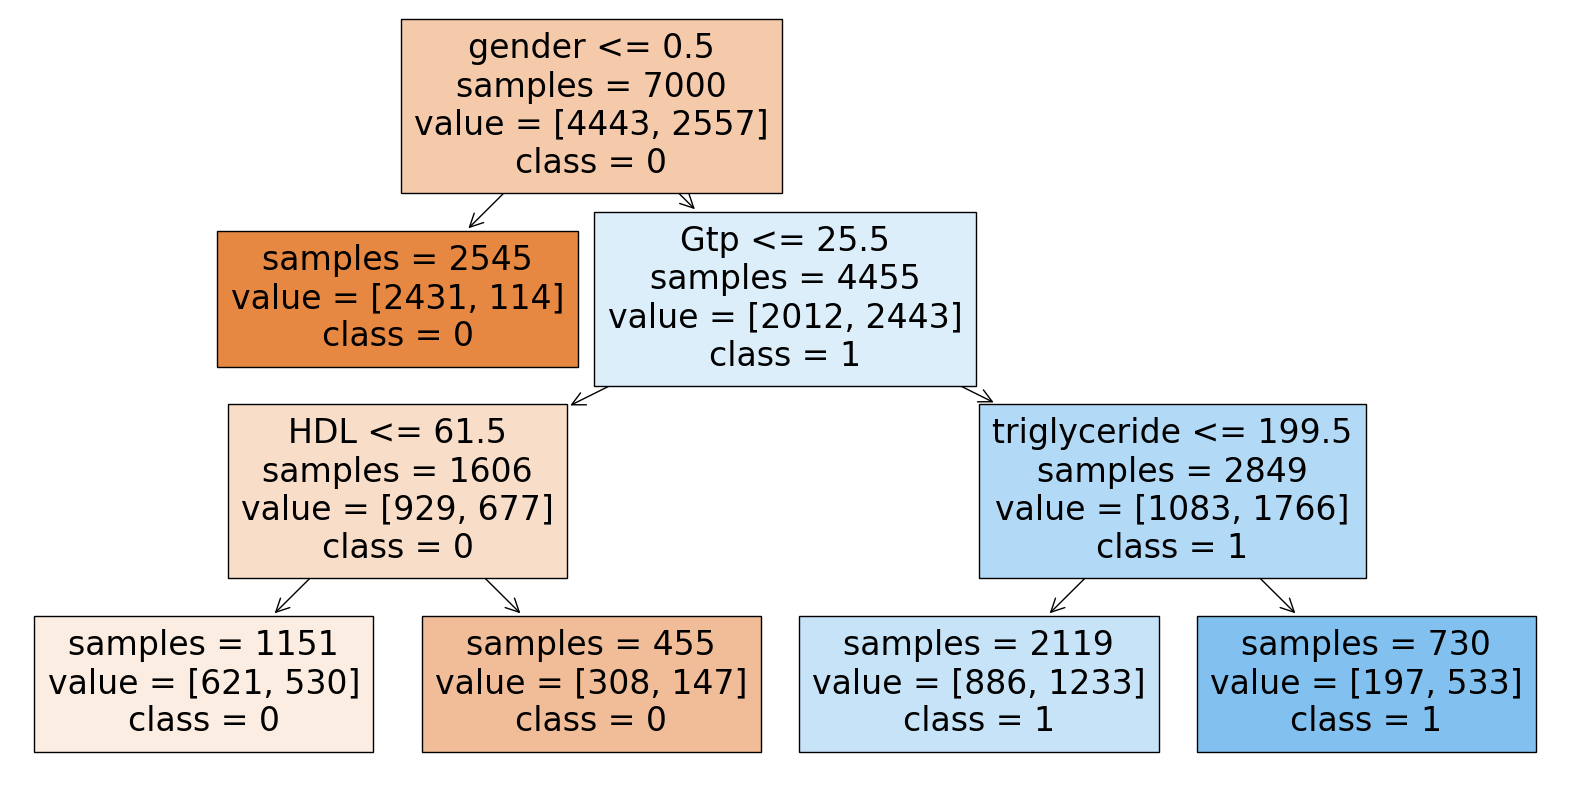

Confusion matrix:
 [[1492  449]
 [ 319  740]]

Accuracy calcolata su cm: 0.744

 Accuracy:  0.744
Test Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1941
           1       0.62      0.70      0.66      1059

    accuracy                           0.74      3000
   macro avg       0.72      0.73      0.73      3000
weighted avg       0.75      0.74      0.75      3000



In [14]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf_pruned,
          feature_names=X_train.columns,
          class_names=[str(x) for x in clf_pruned.classes_],
          filled=True,
          ax=ax,
          impurity=False)

plt.show()
from sklearn.metrics import confusion_matrix

y_pred = clf_pruned.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
accuracy_pruned = clf_pruned.score(X_test, y_test)
print("\n Accuracy: ", accuracy_pruned)

print("Test Set Performance:")
print(classification_report(y_test, y_pred))